<a href="https://colab.research.google.com/github/whistle-hikhi/K-nearest-neighbors/blob/main/ball_tree_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
%load_ext cuml.accel

In [1]:
import numpy as np
from collections import namedtuple
import heapq

In [2]:
BallNode = namedtuple('BallNode', ['centroid', 'radius', 'points', 'values', 'left', 'right'])

In [16]:

class BallTreeKNN:
    def __init__(self, k=3, leaf_size=2):
        self.k = k
        self.leaf_size = leaf_size
        self.root = None
        self.dim = None

    def distance(self, p1, p2):
        """Euclidean distance"""
        return np.sqrt(np.sum((p1 - p2) ** 2))

    def build_tree(self, points, values):
        """Build the Ball Tree recursively"""
        if len(points) <= self.leaf_size:
            centroid = np.mean(points, axis=0)
            radius = max(self.distance(centroid, p) for p in points) if len(points) > 0 else 0
            return BallNode(centroid, radius, points, values, None, None)

        # Find centroid and split points
        centroid = np.mean(points, axis=0)
        distances = np.array([self.distance(centroid, p) for p in points])
        median_idx = np.argsort(distances)

        mid = len(points) // 2
        left_points = points[median_idx[:mid]]
        right_points = points[median_idx[mid:]]
        left_values = values[median_idx[:mid]]
        right_values = values[median_idx[mid:]]

        radius = max(distances) if len(distances) > 0 else 0

        return BallNode(
            centroid=centroid,
            radius=radius,
            points=points,
            values=values,
            left=self.build_tree(left_points, left_values),
            right=self.build_tree(right_points, right_values)
        )

    def fit(self, X, y):
        """Build Ball Tree from training data"""
        self.dim = X.shape[1]
        self.root = self.build_tree(X, y)

    def nearest_neighbors(self, node, point, k, neighbors=None):
        """Find k nearest neighbors"""
        if neighbors is None:
            neighbors = []  # max heap (negative distances)

        if node is None:
            return neighbors

        # If leaf node, check all points
        if node.left is None and node.right is None:
            for p, v in zip(node.points, node.values):
                dist = self.distance(point, p)
                heapq.heappush(neighbors, (-dist, v))
                if len(neighbors) > k:
                    heapq.heappop(neighbors)
            return neighbors

        # Distance to centroid
        dist_to_centroid = self.distance(point, node.centroid)

        # Check both children based on distance bounds
        left_dist = self.distance(point, node.left.centroid) - node.left.radius
        right_dist = self.distance(point, node.right.centroid) - node.right.radius

        # Search closer child first
        if left_dist < right_dist:
            near, far = node.left, node.right
        else:
            near, far = node.right, node.left

        neighbors = self.nearest_neighbors(near, point, k, neighbors)

        # Check if far child needs to be searched
        min_dist = -neighbors[0][0] if neighbors else float('inf')
        if dist_to_centroid - node.radius <= min_dist:
            neighbors = self.nearest_neighbors(far, point, k, neighbors)

        return neighbors

    def predict(self, X_test):
        """Make predictions"""
        predictions = []
        for point in X_test:
            neighbors = self.nearest_neighbors(self.root, point, self.k)
            pred = np.mean([val for _, val in neighbors])
            predictions.append(pred)
        return np.array(predictions)



In [17]:
np.random.seed(42)
X_train = np.array([
    [1, 2], [2, 3], [3, 1],
    [6, 5], [7, 8], [8, 7]
])
y_train = np.array([1.5, 2.0, 1.8, 3.5, 4.0, 3.8])

X_test = np.array([[4, 3], [5, 6]])

# Create and train model
knn = BallTreeKNN(k=3, leaf_size=2)
knn.fit(X_train, y_train)

# Make predictions
predictions = knn.predict(X_test)

# Print results
print("Test points:", X_test)
print("Predictions:", predictions)



Test points: [[4 3]
 [5 6]]
Predictions: [2.43333333 3.76666667]


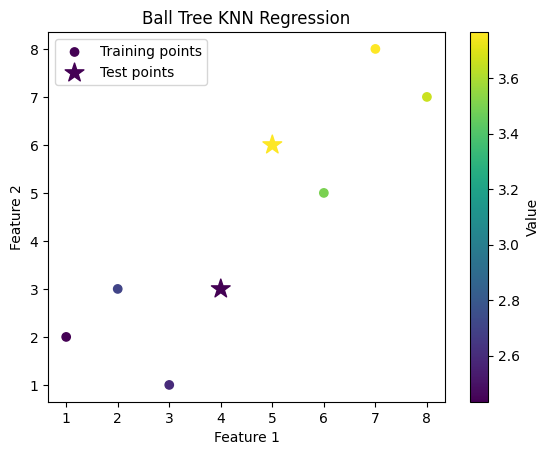

In [18]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
            cmap='viridis', label='Training points')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions,
            cmap='viridis', marker='*', s=200, label='Test points')
plt.colorbar(label='Value')
plt.legend()
plt.title('Ball Tree KNN Regression')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()